<a href="https://colab.research.google.com/github/BaishaliChetia/CapsNet-Keras/blob/master/32X32CapsMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original implementation at:

https://github.com/ageron/handson-ml/blob/master/extra_capsnets.ipynb

Geron's model doesn't use the keras functional API. In the keras functional API, you don't need to give the batchsize. 

When you print the model, you get this:

```
Layer (type)                 Output Shape              Param #   
_________________________________________________________________
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_layer_1 (Conv2D)        (None, 20, 20, 256)       20992     
_________________________________________________________________
conv_layer_2 (Conv2D)        (None, 6, 6, 256)         5308672   
_________________________________________________________________
reshape_layer_1 (Reshape)    (None, 1, 1152, 8)        0         
_________________________________________________________________
caps1_output_layer (SquashLa (None, 1, 1152, 8)        0         
_________________________________________________________________
Total params: 5,329,664
Trainable params: 5,329,664
Non-trainable params: 0
```

Notice that the Input-layer has shape (None, 28, 28, 1), but we only specified (28, 28, 1). It added None implicitly and that takes care of the batch.

So for anywhere Geron uses the batch size explicitly, you don't need to do anything and tensorflow will take care of.

Also note that tensorflow 1 APIs are still provided with the compat layer. I used the reduce_sum from TF1 in the squash layer, that allowed me to use Geron's code.

Documentation on how to migrate from TF1 to TF2 can be found here:

https://www.tensorflow.org/guide/migrate


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd
import tensorflow.keras as K
#import tensorflow_model_optimization as tfmot

In [4]:
pip install -q tensorflow-model-optimization

     |████████████████████████████████| 211 kB 8.3 MB/s 


In [5]:
import tensorflow_model_optimization as tfmot

In [6]:
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 8 * 8  # 1152 primary capsules
caps1_n_dims = 8
caps2_n_caps = 10
caps2_n_dims = 16

tf.random.set_seed(500000)

In [7]:
#class SquashLayer(K.layers.Layer, tfmot.sparsity.keras.PrunableLayer):
class SquashLayer(K.layers.Layer):
  def __init__(self, axis=-1, **kwargs):
    super(SquashLayer, self).__init__(**kwargs)
    self.axis = axis
    
  def build(self, input_shapes):
    pass

  """
  def get_prunable_weights(self):
    return []
  """

  def call(self, inputs):
    EPSILON = 1.0e-9
    squared_norm = tf.compat.v1.reduce_sum(tf.square(inputs),\
                                           axis=self.axis,\
                                           keepdims=True)
    safe_norm = tf.sqrt(squared_norm + EPSILON)
    squash_factor = squared_norm / (1. + squared_norm)
    unit_vector = inputs / safe_norm
    return squash_factor * unit_vector

  def get_config(self):
    config = super(SquashLayer, self).get_config()
    config.update({"axis": self.axis})
    return config

 
#class SafeNorm(K.layers.Layer, tfmot.sparsity.keras.PrunableLayer):
class SafeNorm(K.layers.Layer):
  
  def __init__(self, axis=-1, keep_dims = False,  **kwargs):
    super(SafeNorm, self).__init__(**kwargs)
    self.axis = axis
    self.keep_dims = keep_dims

  def build(self, input_shapes):
    pass

  """
  def get_prunable_weights(self):
    return []
  """

  def call(self, input):
    EPSILON = 1.0e-9
    squared_norm = tf.compat.v1.reduce_sum(tf.square(inputs),\
                                           axis=self.axis,\
                                           keepdims= self.keep_dims)
    safe_norm = tf.sqrt(squared_norm + EPSILON)
    return safe_norm

  def get_config(self):
    config = super(SafeNorm, self).get_config()
    config.update({"axis": self.axis, "keep_dims": self.keep_dims})
    return config
  
# This should be the part where the digit layer, and where we tile things
# This is incomplete, and work in progress
# TODO: Complete this
class MyDigitCapsLayer(K.layers.Layer, tfmot.sparsity.keras.PrunableLayer):
  def __init__(self, **kwargs):
    super(MyDigitCapsLayer, self).__init__(**kwargs)
  
  def get_config(self):
    config =  super(MyDigitCapsLayer, self).get_config()
    return config
  

  def build(self, input_shapes):
    init_sigma = 0.1  # TODO: use
    self.kernel = self.add_weight(\
                      "kernel",\
                      (caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),\
                      initializer="random_normal",\
                      dtype=tf.float32)

  
  # To debug this function, I used prints to print the shape
  # expand_dims just adds an exis, so if you say expand_dims(inshape=(5, 3), -1),
  # you get the output shape (5, 3, 1), it just adds an axis at the end
  # Then tile just multiplies one of the dimensions (that is it stacks along that direction N times)
  # so tile(inshape=(5, 3, 1), [1, 1, 1000]) will yield a shape (5, 3, 1000)
  #
  # Notice I didn't tile in build, but in call, Most probaly this is the right thing to do
  # but we'll only figure out when we actually train
  def get_prunable_weights(self):
    return [self.kernel]
  
  def call(self, inputs):
    # Add a dimension at the end
    exp1 = tf.expand_dims(inputs, -1, name="caps1_output_expanded")
    # add a dimension along 3rd axis
    exp1 = tf.expand_dims(exp1, 2, name="caps2_output_espanced")
    # tile along 3rd axis
    tile = tf.tile(exp1, [1, 1, caps2_n_caps, 1, 1], name="caps1_output_tiled")
    caps2_predicted = tf.matmul(self.kernel, tile, name="caps2_predicted")
    return caps2_predicted

# https://www.tensorflow.org/api_docs/python/tf/keras/losses/Loss
class MarginLoss(K.losses.Loss):
    def __init__(self, **kwargs):
      super(MarginLoss, self).__init__(**kwargs)

  
    def get_config(self):
      config = super(MarginLoss, self).get_config()
      return config
    
    def safe_norm(self, input, axis=-2, epsilon=1e-5, keep_dims=False, name=None):
      squared_norm = tf.reduce_sum(tf.square(input), axis=axis,
                                     keepdims=keep_dims)
      return tf.sqrt(squared_norm + epsilon)

    """
    def get_prunable_weights(self):
      return []
    """

    def call(self,y_true, input):
      # print(f"y_true.shape = {y_true.shape}, y_pred.shape = {y_pred.shape}")
      # return K.losses.MeanSquaredError()(y_true, y_pred)

      #y_true = K.Input(shape=[], dtype=tf.int64, name="y")
      m_plus = 0.9
      m_minus = 0.1
      lambda_ = 0.5 
      
      #y_true one hot encode y_train
      T = tf.one_hot(y_true, depth=caps2_n_caps, name="T")
      
      caps2_output_norm = self.safe_norm(input, keep_dims = True)

      present_error_raw = tf.square(\
                                    tf.maximum(0., m_plus - caps2_output_norm),
                                    name="present_error_raw")
      present_error = tf.reshape(\
                                    present_error_raw, shape=(-1, 10),
                                    name="present_error")  
  
      absent_error_raw = tf.square(\
                                    tf.maximum(0., caps2_output_norm - m_minus),
                                    name="absent_error_raw")
      absent_error = tf.reshape(\
                                    absent_error_raw, shape=(-1, 10),
                                    name="absent_error")
  
      L = tf.add(\
                  T * present_error,\
                  lambda_ * (1.0 - T) * absent_error,
                  name="L")
      marginLoss = tf.reduce_mean(\
                                  tf.reduce_sum(L, axis=1),\
                                  name="margin_loss")
      return marginLoss


#class RoutingByAgreement(K.layers.Layer, tfmot.sparsity.keras.PrunableLayer):
class RoutingByAgreement(K.layers.Layer):
  def __init__(self, round_number=-1, **kwargs):
    super(RoutingByAgreement, self).__init__(**kwargs)
    self.round_number = round_number 

  def get_config(self):
    config = super(RoutingByAgreement, self).get_config()
    config.update({"round_number": self.round_number})
    return config
 

  def build(self, input_shapes):
    self.raw_weights_1 = self.add_weight("raw_weights", \
                                         (caps1_n_caps, caps2_n_caps, 1, 1), \
                                         initializer = "zeros", \
                                         dtype=tf.float32,)
    
    #print("Routing layer: self.raw_weights = ", self.raw_weights.shape, "input_shape = ", input_shapes)

  
  def get_prunable_weights(self):
    return [self.raw_weights_1]


  @staticmethod
  def squash(inputs):
    EPSILON = 1.0e-5
    squared_norm = tf.compat.v1.reduce_sum(tf.square(inputs),\
                                           keepdims=True)
    safe_norm = tf.sqrt(squared_norm + EPSILON)
    squash_factor = squared_norm / (1. + squared_norm)
    unit_vector = inputs / safe_norm
    return squash_factor * unit_vector

  def single_round_routing(self, inputs, raw_weights, agreement):
    raw_weights = tf.add(raw_weights, agreement)
    routing_wt = tf.nn.softmax(raw_weights, axis=2)
    wt_predictions = tf.multiply(routing_wt, inputs)
    wt_sum = tf.reduce_sum(wt_predictions, axis=1, keepdims=True)
    return wt_sum

  def call(self, inputs):
    agreement = tf.zeros(shape=self.raw_weights_1.shape)
    sqsh_wt_sum = None
    x = inputs
    for i in range(2):
      wt_sum = self.single_round_routing(inputs, self.raw_weights_1, agreement)
      sqsh_wt_sum = RoutingByAgreement.squash(wt_sum)
      sqsh_wt_sum_tiled = tf.tile(\
                          sqsh_wt_sum ,\
                          [1, caps1_n_caps, 1, 1, 1],\
                          name="caps2_output_round_1_tiled")
      agreement = tf.matmul(\
                            x, \
                            sqsh_wt_sum_tiled,\
                            transpose_a=True,\
                            name="agreement")
    return sqsh_wt_sum

class MyAccuracy(K.metrics.Metric):
  def __init__(self, **kwargs):
    super(MyAccuracy, self).__init__(**kwargs)
    self.acc_obj = K.metrics.Accuracy()
    self.state = 0
  

  def get_config(self):
    config = super(MyAccuracy, self).get_config()
    config.update({"acc_obj": None, "state": self.state})
    return config
  

  def safe_norm(self, input, axis=-2, epsilon=1e-5, keep_dims=True, name=None):
      squared_norm = tf.reduce_sum(tf.square(input), axis=axis,
                                     keepdims=keep_dims)
      return tf.sqrt(squared_norm + epsilon)

  def update_state(self, y_true, input, sample_weight=None):
    if self.acc_obj is None:
      self.acc_obj = K.metrics.Accuracy()
    y_proba = self.safe_norm(input, axis=-2)
    y_proba_argmax = tf.argmax(y_proba, axis=2)
    y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")
    #y_true = tf.reshape(y_true, (y_true.shape[0], ))
    y_true = tf.cast(y_true, dtype=tf.int64)
    self.acc_obj.update_state(y_true, y_pred, sample_weight)

  def reset_state(self):
    self.acc_obj.reset_state()

  def result(self):
    return self.acc_obj.result()

class MyReshapeLayer(K.layers.Layer):
  def __init__(self, axis=-1, keep_dims = False,  **kwargs):
    super(MyReshapeLayer, self).__init__(**kwargs)

  def build(self, input_shapes):
    pass

  def safe_norm(self, input, axis=-2, epsilon=1e-5, keep_dims=True, name=None):
      squared_norm = tf.reduce_sum(tf.square(input), axis=axis,
                                     keepdims=keep_dims)
      return tf.sqrt(squared_norm + epsilon)

  def call(self, input):
    print('printing shapes ------------------- ')
    EPSILON = 1.0e-9
    print(input)
    y_proba = self.safe_norm(input, axis=-2)
    print(y_proba)
    y_proba_argmax = tf.argmax(y_proba, axis=2)
    print(y_proba_argmax)
    y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")
    print(y_pred)
    return tf.cast(y_pred, tf.int64)

  def get_config(self):
    config = super(MyReshapeLayer, self).get_config()
    return config
  

In [8]:
(x_train, y_train,), (x_test, y_test) = K.datasets.mnist.load_data()
#print(x_train.shape, x_test.shape)
x_train = x_train/255.0
x_test = x_test/255.0

11501568/11490434 [==============================] - 0s 0us/step


In [9]:
x_train.shape

(60000, 28, 28)

In [10]:
import keras
tf.random.set_seed(500000)
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = K.datasets.mnist.load_data()

# Normalize the input image so that each pixel value is between 0 and 1.
train_images = train_images / 255.0
test_images = test_images / 255.0
train_X =[]

for i in range(train_images.shape[0]):
  train_pad = np.pad(train_images[i], pad_width=2 , mode= 'edge')
  #print(train_pad)
  train_X.append(train_pad)
#PADDING test images
test_X = []
for i in range(test_images.shape[0]):
  test_pad = np.pad(test_images[i], pad_width=2 , mode= 'edge')
  #print(train_pad)
  test_X.append(test_pad)
train_X = np.array(train_X)
test_X = np.array(test_X)

In [11]:
train_X.shape, test_X.shape

((60000, 32, 32), (10000, 32, 32))

In [12]:
x_train = train_X
x_test = test_X
x_train.shape, x_test.shape

((60000, 32, 32), (10000, 32, 32))

In [13]:
class Model:
    @staticmethod
    def build(inshape=(32, 32, 1)):
        inp = K.Input(shape=inshape, dtype=tf.float32, name='input')
        
        # Primary capsules
        # For each digit in the batch
        # 32 maps, each 6x6 grid of 8 dimensional vectors
        
        # First Conv layer
        conv1_params = \
        {
            "filters": 256,
            "kernel_size": 9,
            "strides": 1,
            "padding": "valid",
            "activation": tf.nn.relu,
        }
        x = K.layers.Conv2D(**conv1_params, name="conv_layer_1")(inp)
        
        # Second conv layer
        conv2_params = \
        {
            "filters": caps1_n_maps * caps1_n_dims, # 256 convolutional filters
            "kernel_size": 9,
            "strides": 2,
            "padding": "valid",
            "activation": tf.nn.relu
        }
        x = K.layers.Conv2D(**conv2_params, name="conv_layer_2")(x)
        
        # Reshape
        x = K.layers.Reshape(\
                             (caps1_n_caps, caps1_n_dims),\
                             name="reshape_layer_1")(x)
                             
        x = SquashLayer(name="caps1_output_layer")(x)
        
        x = MyDigitCapsLayer(name = "caps2_predicted")(x)
        caps2_predicted = x # Save this value for later
        
        #routing by agreement (2 rounds)
        x = RoutingByAgreement(name="routing1", round_number=2)(x)
        
        return K.Model(inputs=inp, outputs=x, name='my')
    
m = Model.build()
print(m.summary())


Model: "my"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv_layer_1 (Conv2D)        (None, 24, 24, 256)       20992     
_________________________________________________________________
conv_layer_2 (Conv2D)        (None, 8, 8, 256)         5308672   
_________________________________________________________________
reshape_layer_1 (Reshape)    (None, 2048, 8)           0         
_________________________________________________________________
caps1_output_layer (SquashLa (None, 2048, 8)           0         
_________________________________________________________________
caps2_predicted (MyDigitCaps (None, 2048, 10, 16, 1)   2621440   
_________________________________________________________________
routing1 (RoutingByAgreement (None, 1, 10, 16, 1)      20480    

In [ ]:
# y_train_train = tf.one_hot(y_train, depth=caps2_n_caps, name="T")
# print(y_train_train.shape)
# #print(y_train)

In [24]:
from keras.callbacks import ModelCheckpoint, CSVLogger
comparison_metric = MyAccuracy()
#checkpoint_filepath = "/content/drive/MyDrive/Weights/weights-improvement-{epoch:02d}-{val_my_accuracy:.2f}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = "/content/drive/MyDrive/MnistResults/caps32X32_best_weights5.hdf5",
        save_weights_only=True,
        #monitor=f"val_{comparison_metric.name}",
        monitor="val_my_accuracy_5",
        mode='max',
        save_best_only=True)
model_checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
        filepath = "/content/drive/MyDrive/MnistResults/latest_weights5.hdf5",
        save_weights_only=True,
        monitor=f"val_{comparison_metric.name}",
        mode='max',
        save_best_only=False)
log_csv = CSVLogger("/content/drive/MyDrive/MnistResults/caps32X32mylogs5.csv", separator = ",", append = False)
callback_list = [model_checkpoint_callback,log_csv]

In [ ]:
comparison_metric.name

'my_accuracy'

In [22]:
m.compile(optimizer='adam', loss=MarginLoss(), metrics=[MyAccuracy()])


In [25]:
m.compile(optimizer='adam', loss=MarginLoss(), metrics=[MyAccuracy()])
history = m.fit(x_train, y_train, batch_size=32, epochs=50, verbose= 1, validation_split=0.1, callbacks= callback_list)


Epoch 1/50
1688/1688 [==============================] - 222s 131ms/step - loss: 2.2799 - my_accuracy_5: 0.2366 - val_loss: 2.2762 - val_my_accuracy_5: 0.4755
Epoch 2/50
1688/1688 [==============================] - 222s 132ms/step - loss: 2.2789 - my_accuracy_5: 0.5361 - val_loss: 2.2761 - val_my_accuracy_5: 0.7740
Epoch 3/50
1688/1688 [==============================] - 215s 127ms/step - loss: 2.2786 - my_accuracy_5: 0.6670 - val_loss: 2.2760 - val_my_accuracy_5: 0.8867
Epoch 4/50
1688/1688 [==============================] - 217s 129ms/step - loss: 2.2784 - my_accuracy_5: 0.6974 - val_loss: 2.2756 - val_my_accuracy_5: 0.8900
Epoch 5/50
1688/1688 [==============================] - 214s 126ms/step - loss: 2.2783 - my_accuracy_5: 0.7738 - val_loss: 2.2757 - val_my_accuracy_5: 0.9065
Epoch 6/50
1688/1688 [==============================] - 214s 127ms/step - loss: 2.2782 - my_accuracy_5: 0.8085 - val_loss: 2.2760 - val_my_accuracy_5: 0.8132
Epoch 7/50
1688/1688 [==============================

In [ ]:
# import time
# class TimeHistory(K.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#         self.times = []

#     def on_epoch_begin(self, batch, logs={}):
#         self.epoch_time_start = time.time()

#     def on_epoch_end(self, batch, logs={}):
#         self.times.append(time.time() - self.epoch_time_start)
# time_callback = TimeHistory()
# history = m.fit(x_train, y_train, batch_size=32, epochs=50, verbose= 1, validation_split=0.1, callbacks = [time_callback, model_checkpoint_callback, log_csv])
# times = time_callback.times
# print(times)

In [35]:
x_train.shape

(60000, 32, 32)

In [26]:
print(f'Best Validation Accuracy = {np.max(history.history["val_my_accuracy_5"])}')
print(f'Best Training   Accuracy = {np.max(history.history["my_accuracy_5"])}')

Best Validation Accuracy = 0.9781666398048401
Best Training   Accuracy = 0.9480925798416138


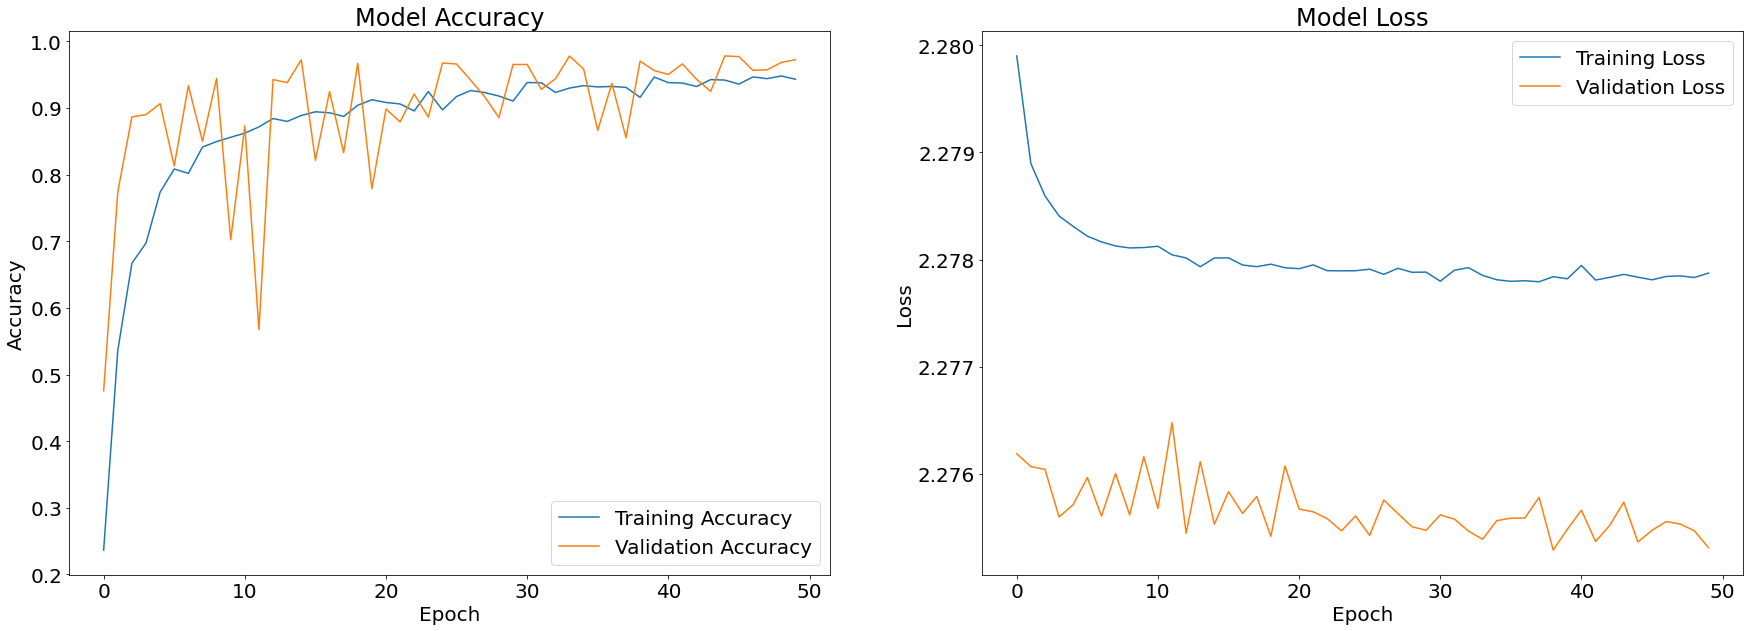

In [27]:

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (30, 10)
plt.rcParams["font.size"] = 20

fig, ax = plt.subplots(1, 2)

ax[0].plot(history.history['my_accuracy_5'])
ax[0].plot(history.history['val_my_accuracy_5'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Training Accuracy', 'Validation Accuracy'], loc='best')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Training Loss', 'Validation Loss'], loc='best')
plt.show()

In [30]:
m.load_weights("/content/drive/MyDrive/MnistResults/caps32X32_best_weights5.hdf5")
m.save("/content/drive/MyDrive/MnistResults/caps32X32_basemodel_1.tf", save_format='tf')


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MnistResults/caps32X32_basemodel_1.tf/assets


# Caps 32X32 base model size .tf = 92M

In [31]:
m.evaluate(test_X, test_labels, verbose = 1)

313/313 [==============================] - 19s 60ms/step - loss: 2.2765 - my_accuracy_5: 0.9745


[2.276534080505371, 0.9745000004768372]

In [37]:
print("time for caps model evaluation: " + str((19/test_X.shape[0])*1000) + "ms")

time for caps model evaluation: 1.9ms


# time for caps model evaluation: 1.9ms

In [32]:
#Extra layer for evaluate
class DimensionCorrection(K.layers.Layer):
    def __init__(self, **kwargs):
      super(DimensionCorrection, self).__init__(**kwargs)
    
    def safe_norm(self, input, axis=-2, epsilon=1e-7, keep_dims=False, name=None):
      squared_norm = tf.reduce_sum(tf.square(input), axis=axis,
                                     keepdims=keep_dims)
      return tf.sqrt(squared_norm + epsilon)

    def call(self,y_pred):
      y_proba = self.safe_norm(y_pred, axis=-2)
      y_proba_argmax = tf.argmax(y_proba, axis=2)
      y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")
      return y_pred



In [ ]:
# y_test = tf.cast(y_test, dtype= tf.int64)
# print(y_test.shape)

In [34]:
m = Model.build()
m.load_weights('/content/drive/MyDrive/MnistResults/caps32X32_best_weights5.hdf5')
m.compile(optimizer='Adam', loss=MarginLoss)
newmodel = K.models.Sequential(\
            [\
            m,\
            DimensionCorrection(),\
            ]\
)
newmodel.summary()
m.trainable = False
newmodel.compile(optimizer='adam')

y_pred = newmodel.predict(x_test)

import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
print(confusion_matrix(y_test, y_pred))
print(f"accuracy = {accuracy_score(y_test, y_pred)}")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my (Functional)              (None, 1, 10, 16, 1)      7971584   
_________________________________________________________________
dimension_correction (Dimens (None,)                   0         
Total params: 7,971,584
Trainable params: 7,971,584
Non-trainable params: 0
_________________________________________________________________
[[ 975    2    1    0    0    0    1    1    0    0]
 [   0 1130    4    0    0    0    0    1    0    0]
 [   0    2 1018    0    0    0    0   11    1    0]
 [   0    1    2  991    0    1    0   10    4    1]
 [   1    8    0    0  932    0    5    5    3   28]
 [   2   41    1   24    0  800    3   11    8    2]
 [   6   10    0    0    0    0  941    0    1    0]
 [   0    5    6    0    0    0    0 1016    0    1]
 [   2    1    3    0    0    0    0    5  961    2]
 [   1    6    1    3    2    0

In [38]:
mm = m

In [40]:
converter = tf.lite.TFLiteConverter.from_keras_model(m)

In [42]:
# Create the .tflite file
tflite_model_file = "/content/drive/MyDrive/MnistResults/caps32X32_compressedB.tflite"
converter = tf.lite.TFLiteConverter.from_keras_model(mm)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

tflite_model = converter.convert()
with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp62gwulbv/assets


INFO:tensorflow:Assets written to: /tmp/tmp62gwulbv/assets


# Capsule 32X32 on compression without pruning = 16M

In [ ]:
!du -sh /content/drive/MyDrive/MnistResults/*

# Use this tutorial for pruning
quantization has already been done earlier

https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras


# Pruning of 32X32 Capsule Network 

# testing all pruning percentage first


In [48]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = train_images.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

list_accuracy0 = []
finalSparsity = 0.05
while finalSparsity <= 0.95:
  mm = m
  mm.load_weights('/content/drive/MyDrive/MnistResults/caps32X32_best_weights5.hdf5')

 
  pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.0,
                                                                final_sparsity=finalSparsity,
                                                                begin_step=0,
                                                                end_step=end_step)
  }


  ######################################################################
  logdir = tempfile.mkdtemp()

  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  ]

  # Helper function uses `prune_low_magnitude` to make only the 
  # Dense layers train with pruning.
  def apply_pruning_to_layers(layer):
    #print("called")
    if isinstance(layer, MyDigitCapsLayer):
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "conv_layer_2":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "routing1":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    elif layer.name == "conv_layer_1":
      print(f"Layer {layer} {layer.name} slated for pruning")
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)


    print(f"Layer {layer} {layer.name} unchanged")
    return layer

  # Use `tf.keras.models.clone_model` to apply `apply_pruning_to_layers` 
  # to the layers of the model.
  model_for_pruning = tf.keras.models.clone_model(
      mm,
      clone_function=apply_pruning_to_layers,
  )
  #print(model_for_pruning.summary())

  """
  model_for_pruning = K.models.Sequential(\
                [\
                  model_for_pruning,\
                  MyReshapeLayer(),\
                ]\
  )
  """


  model_for_pruning.compile(optimizer='adam', loss=MarginLoss(), metrics=[MyAccuracy()])
  #model_for_pruning.compile(optimizer='adam', loss=MarginLoss())

  model_for_pruning.fit(x_train, y_train,
                    batch_size=32, epochs=2, validation_split=validation_split,
                    callbacks=callbacks)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(x_test, y_test, verbose=1)
  
  list_accuracy0.append(model_for_pruning_accuracy)
  print(f"prunned accuracy at final sparsity {finalSparsity} is {model_for_pruning_accuracy}")
  finalSparsity+= 0.05
  list_accuracy0.append(model_for_pruning_accuracy)
print("accuracy list: ", list_accuracy0)

Layer <keras.layers.convolutional.Conv2D object at 0x7faf52da3750> conv_layer_1 slated for pruning
Layer <keras.layers.convolutional.Conv2D object at 0x7faf52da3b90> conv_layer_2 slated for pruning
Layer <keras.layers.core.Reshape object at 0x7faf52dacb50> reshape_layer_1 unchanged
Layer <__main__.SquashLayer object at 0x7faf52dad190> caps1_output_layer unchanged
Layer <__main__.MyDigitCapsLayer object at 0x7faf7c23e250> caps2_predicted slated for pruning
Layer <__main__.RoutingByAgreement object at 0x7faf52da4210> routing1 slated for pruning


/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/2
1688/1688 [==============================] - 125s 73ms/step - loss: 2.2777 - my_accuracy_10: 0.9738 - val_loss: 2.2754 - val_my_accuracy_10: 0.9780
Epoch 2/2
313/313 [==============================] - 18s 59ms/step - loss: 2.2765 - my_accuracy_10: 0.9745
prunned accuracy at final sparsity 0.05 is 0.9745000004768372
Layer <keras.layers.convolutional.Conv2D object at 0x7faf52da3750> conv_layer_1 slated for pruning
Layer <keras.layers.convolutional.Conv2D object at 0x7faf52da3b90> conv_layer_2 slated for pruning
Layer <keras.layers.core.Reshape object at 0x7faf52dacb50> reshape_layer_1 unchanged
Layer <__main__.SquashLayer object at 0x7faf52dad190> caps1_output_layer unchanged
Layer <__main__.MyDigitCapsLayer object at 0x7faf7c23e250> caps2_predicted slated for pruning
Layer <__main__.RoutingByAgreement object at 0x7faf52da4210> routing1 slated for pruning
Epoch 1/2
1688/1688 [==============================] - 127s 74ms/step - loss: 2.2777 - my_accuracy_11: 0.9738 - val_loss: 2.

In [49]:
print(len(list_accuracy0))

36


# Now Pruning 65% of weights

In [50]:
import tensorflow_model_optimization as tfmot
import tempfile

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# TODO: Remove this line
#m.load_weights('/content/drive/MyDrive/MnistResults/best_weights4.hdf5')

# print("ORIGINAL MODEL")
# print(mm.summary())
# print('-' * 80)

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = x_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

mm = m
mm.load_weights('/content/drive/MyDrive/MnistResults/caps32X32_best_weights5.hdf5')

# Define model for pruning.
# pruning_params = {
#       'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
#                                                                final_sparsity=0.80,
#                                                                begin_step=0,
#                                                                end_step=end_step)
# }

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.20,
                                                              final_sparsity=0.65,
                                                              begin_step=0,
                                                              end_step=end_step)
}

"""
model_for_pruning = prune_low_magnitude(mm, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=MarginLoss(), metrics=[MyAccuracy()])

model_for_pruning.summary()

"""


######################################################################
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

# Helper function uses `prune_low_magnitude` to make only the 
# Dense layers train with pruning.
def apply_pruning_to_layers(layer):
  #print("called")
  if isinstance(layer, MyDigitCapsLayer):
    print(f"Layer {layer} {layer.name} slated for pruning")
    return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
  elif layer.name == "conv_layer_2":
    print(f"Layer {layer} {layer.name} slated for pruning")
    return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
  elif layer.name == "routing1":
    print(f"Layer {layer} {layer.name} slated for pruning")
    return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
  elif layer.name == "conv_layer_1":
    print(f"Layer {layer} {layer.name} slated for pruning")
    return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)


  print(f"Layer {layer} {layer.name} unchanged")
  return layer

# Use `tf.keras.models.clone_model` to apply `apply_pruning_to_layers` 
# to the layers of the model.
model_for_pruning = tf.keras.models.clone_model(
    mm,
    clone_function=apply_pruning_to_layers,
)
#print(model_for_pruning.summary())

"""
model_for_pruning = K.models.Sequential(\
              [\
                model_for_pruning,\
                MyReshapeLayer(),\
              ]\
)
"""


model_for_pruning.compile(optimizer='adam', loss=MarginLoss(), metrics=[MyAccuracy()])
#model_for_pruning.compile(optimizer='adam', loss=MarginLoss())

model_for_pruning.fit(x_train, y_train,
                  batch_size=32, epochs=2, validation_split=validation_split,
                  callbacks=callbacks, verbose = 1)
_, model_for_pruning_accuracy = model_for_pruning.evaluate(x_test, y_test, verbose=1)

Layer <keras.layers.convolutional.Conv2D object at 0x7faf52da3750> conv_layer_1 slated for pruning
Layer <keras.layers.convolutional.Conv2D object at 0x7faf52da3b90> conv_layer_2 slated for pruning
Layer <keras.layers.core.Reshape object at 0x7faf52dacb50> reshape_layer_1 unchanged
Layer <__main__.SquashLayer object at 0x7faf52dad190> caps1_output_layer unchanged
Layer <__main__.MyDigitCapsLayer object at 0x7faf7c23e250> caps2_predicted slated for pruning
Layer <__main__.RoutingByAgreement object at 0x7faf52da4210> routing1 slated for pruning


/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/2
1688/1688 [==============================] - 135s 79ms/step - loss: 2.2780 - my_accuracy_28: 0.9594 - val_loss: 2.2755 - val_my_accuracy_28: 0.9623
Epoch 2/2
313/313 [==============================] - 18s 59ms/step - loss: 2.2767 - my_accuracy_28: 0.9572


In [51]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 19s 59ms/step - loss: 2.2767 - my_accuracy_28: 0.9572


In [52]:
print("evaluation time for prunned model : " +str((19/x_test.shape[0])*1000) + "ms")

evaluation time for prunned model : 1.9ms


# Prune model accuracy = 0.9572 and pruned model evaluation time = 1.9ms

In [55]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
model_for_export.summary()
pruned_keras_file = "/content/drive/MyDrive/MnistResults/caps32X32pruned_fileB.tf"
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Model: "my"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv_layer_1 (Conv2D)        (None, 24, 24, 256)       20992     
_________________________________________________________________
conv_layer_2 (Conv2D)        (None, 8, 8, 256)         5308672   
_________________________________________________________________
reshape_layer_1 (Reshape)    (None, 2048, 8)           0         
_________________________________________________________________
caps1_output_layer (SquashLa (None, 2048, 8)           0         
_________________________________________________________________
caps2_predicted (MyDigitCaps (None, 2048, 10, 16, 1)   2621440   
_________________________________________________________________
routing1 (RoutingByAgreement (None, 1, 10, 16, 1)      20480    

INFO:tensorflow:Assets written to: /content/drive/MyDrive/MnistResults/caps32X32pruned_fileB.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MnistResults/caps32X32pruned_fileB.tf/assets


Saved pruned Keras model to: /content/drive/MyDrive/MnistResults/caps32X32pruned_fileB.tf


# size of Caps Pruned file = 31M

# Now compression after pruning

In [61]:
#converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
tflite_model_file = "/content/drive/MyDrive/MnistResults/caps32X32_P&Q_1.tflite"
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

tflite_model = converter.convert()
with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpwsg6s5ia/assets


INFO:tensorflow:Assets written to: /tmp/tmpwsg6s5ia/assets


In [58]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [2]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size("/content/drive/MyDrive/MnistResults/caps32X32_basemodel_1.tf")))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(tflite_model_file)))

NameError: ignored

In [63]:
tflite_model_file = "/content/drive/MyDrive/MnistResults/caps32X32_P&Q_1_noZip.tflite"
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

tflite_model = converter.convert()
with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpv1z816sm/assets


INFO:tensorflow:Assets written to: /tmp/tmpv1z816sm/assets


Model size, pruned and quantized, no zip = 16M
# Model size, pruned, quantized and zipped = 6.6M

In [64]:
!du -sh /content/drive/MyDrive/MnistResults/*

27M	/content/drive/MyDrive/MnistResults/best_weights4.hdf5
27M	/content/drive/MyDrive/MnistResults/best_weights5.hdf5
92M	/content/drive/MyDrive/MnistResults/caps32X32_basemodel_1.tf
31M	/content/drive/MyDrive/MnistResults/caps32X32_best_weights5.hdf5
16M	/content/drive/MyDrive/MnistResults/caps32X32_compressedB.tflite
4.0K	/content/drive/MyDrive/MnistResults/caps32X32mylogs5.csv
16M	/content/drive/MyDrive/MnistResults/caps32X32_P&Q_1_noZip.tflite
16M	/content/drive/MyDrive/MnistResults/caps32X32_P&Q_1.tflite
31M	/content/drive/MyDrive/MnistResults/caps32X32pruned_fileB.h5
31M	/content/drive/MyDrive/MnistResults/caps32X32pruned_fileB.tf
3.0K	/content/drive/MyDrive/MnistResults/caps48X48mylogs5.csv
27M	/content/drive/MyDrive/MnistResults/caps_basemodel28X28_1.h5
1.0K	/content/drive/MyDrive/MnistResults/caps_basemodelA.h5
27M	/content/drive/MyDrive/MnistResults/caps_basemodelA.tf
27M	/content/drive/MyDrive/MnistResults/caps_basemodelB.tf
27M	/content/drive/MyDrive/MnistResults/caps_best_

In [60]:
from tensorflow.keras.models import load_model

model = model_for_export
import numpy as np

for i, w in enumerate(model.get_weights()):
  print("{} -- Total:{}, Zeros: {:.2f}%".format(model.weights[i].name, w.size, np.sum(w == 0) / w.size * 100))
    

conv_layer_1/kernel:0 -- Total:20736, Zeros: 64.99%
conv_layer_1/bias:0 -- Total:256, Zeros: 0.00%
conv_layer_2/kernel:0 -- Total:5308416, Zeros: 64.99%
conv_layer_2/bias:0 -- Total:256, Zeros: 0.00%
caps2_predicted/kernel:0 -- Total:2621440, Zeros: 64.99%
routing1/raw_weights:0 -- Total:20480, Zeros: 65.00%


tyoes of post training quantization
https://www.tensorflow.org/lite/performance/post_training_quantization

In [65]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0x1
cpu MHz		: 2000.190
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	:

In [66]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         148G   38G  110G  26% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
tmpfs           6.4G  184K  6.4G   1% /var/colab
/dev/sda1       154G   41G  113G  27% /opt/bin/.nvidia
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G  7.7G  7.4G  51% /content/drive


In [67]:
!cat /proc/meminfo

MemTotal:       13302916 kB
MemFree:          159924 kB
MemAvailable:   10183588 kB
Buffers:          223612 kB
Cached:          6213900 kB
SwapCached:            0 kB
Active:          3432676 kB
Inactive:        9172856 kB
Active(anon):    2438920 kB
Inactive(anon):    14812 kB
Active(file):     993756 kB
Inactive(file):  9158044 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               468 kB
Writeback:             0 kB
AnonPages:       6168112 kB
Mapped:          1669512 kB
Shmem:             15668 kB
KReclaimable:     197916 kB
Slab:             264860 kB
SReclaimable:     197916 kB
SUnreclaim:        66944 kB
KernelStack:        6204 kB
PageTables:        23808 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6651456 kB
Committed_AS:    9627868 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       52480 kB
VmallocChunk:          0 kB
Percpu:          

In [68]:
!nvidia-smi
print()
print()
print('=' * 80)
print()
print()
!df -h
print()
print()
print('=' * 80)
print()
print()
!free -m
print()
print()
print('=' * 80)
print()
print()
!lscpu
print()
print()
print('=' * 80)
print()
print()
! ps -eo pmem,pcpu,vsize,pid,cmd | sort -k 1 -nr | head -5

Wed Aug 25 16:44:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    27W /  70W |   4962MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------